In [108]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as mplot
import scipy.integrate as integrate
import numpy.linalg as LA
import csv
from scipy import signal
from IPython.display import Image, display

# Averaging over Agent-Based SIR Model

Here, we are taking data from an agent-based model and looking at the results in producing a "large-scale" or global model. The data is a time-series of a population of 500 over 100 time steps. We hope to recover something similar to an SIR model, given different parameters that can control our regression.

A few things to note:
\begin{itemize}
\item We are using py.SINDy to run the regressions. This is more robust than my code and performs as expected. 
\item We use a threshold regressions ``stlsq`` in py.SINDy. This amounts to minimizing 
$$
||\dot{x} - \Theta\xi||_2^2+\alpha||\xi||_2^2
$$
with a sequencial thresholding (ie. if an entry falls below the threshold, we set it to 0).
\item We are running multiple possible situations to highlight the possibilities of the SINDy. However, we will use this as motivation for finding potiential governing equations. One thing that could help is using mutliple trajectories/agent-based simulations to help reduce the amount of noise in the system. 

## The Coding

We start by importing the information and looking at different potential moving averages.

In [109]:
#%% Setting up the problem
Agent_based = []

### Import the Data
with open('sir_abm_test.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        # print(row)
        Agent_based.append(row)
        
        
## Put Data in proper format
Agent_based = np.array(Agent_based)
Agent_based = np.array(Agent_based, dtype = np.float64)

## Set up important information 
n = Agent_based.shape[0]    # length of time-series
time = np.arange(0,n)       # set up time mesh
dt = 1

### Noise Reduction

We now consider different methods of reducing the noise in the system. In this example, we use the Savitzky-Golay filter which uses polynomials of a specified degree to eliminated extra noise. In this case, we use linear functions as they act as a moving average. We consider taking a wider range of possible points below. As expected, if we take a wider window of our average, the peak becomes less pronouced. 

Text(0.5, 1.0, 'Infected populations with varying width of averages')

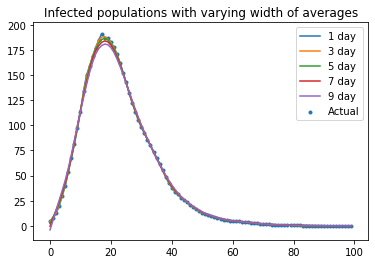

In [110]:
Original = Agent_based
title = 'Infected populations with varying width of averages'
fig = mplot.figure()
ax1 = mplot.axes()

# Run without averaging
X_S = sp.signal.savgol_filter(Original[:,0],1,0)
X_I = sp.signal.savgol_filter(Original[:,1],1,0)
X_R = sp.signal.savgol_filter(Original[:,2],1,0)
Agent_based_new = np.column_stack([X_S, X_I, X_R])
Agent_based = Agent_based_new
ax1.plot(time,Agent_based[:,1])

# Run with varying averages
for i in range(1,5):
    X_S = sp.signal.savgol_filter(Original[:,0],int(2*i+1),1)
    X_I = sp.signal.savgol_filter(Original[:,1],int(2*i+1),1)
    X_R = sp.signal.savgol_filter(Original[:,2],int(2*i+1),1)
    Agent_based_new = np.column_stack([X_S, X_I, X_R])
    Agent_based = Agent_based_new
    ax1.plot(time,Agent_based[:,1])
    
    
ax1.scatter(np.arange(0,n), Original[:,1], marker = '.')
ax1.legend(['1 day','3 day','5 day', '7 day', '9 day', 'Actual'])
ax1.set_title(title)

We now consider running this smoothed information through SINDy to see what results it produces. As discussed, we use a threshold regression tool. We will use a 5-day average to approximate our data for SINDy. Further analysis into varying this is given later.

### Using SINDy

In [111]:
X_S = sp.signal.savgol_filter(Original[:,0],5,1)
X_I = sp.signal.savgol_filter(Original[:,1],5,1)
X_R = sp.signal.savgol_filter(Original[:,2],5,1)
Agent_based_new = np.column_stack([X_S, X_I, X_R])
Agent_based = Agent_based_new


import pysindy as ps
from sklearn.linear_model import Lasso

### Set up optimization/regression tools 
stlsq_optimizer = ps.STLSQ(threshold=0.00001,  alpha=1, max_iter = 100)         # Sequential Threshold
lasso_optimizer = Lasso(alpha=20000, fit_intercept=False, max_iter = 1000)   # Lasso
sr3_optimizer = ps.SR3(threshold=0.00001, nu=10) 

### Fit the Model
model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(Agent_based, 1)
model.print(lhs = ['S`','I`','R`'],precision = 7)

S` = -0.0000210 x0^2 + -0.0006065 x0 x1 + -0.0000165 x0 x2 + -0.0001356 x1^2
I` = 0.0000197 x0^2 + 0.0004152 x0 x1 + -0.0000192 x0 x2 + -0.0000788 x1^2 + -0.0002089 x1 x2
R` = 0.0002012 x0 x1 + 0.0000253 x0 x2 + 0.0002125 x1^2 + 0.0002110 x1 x2


Here x0 is $S$, x1 is $I$, and x2 is $R$ and we can plot the resulting simulations against the original data. 

Text(0.5, 1.0, 'Simulated ODE vs. Original Data')

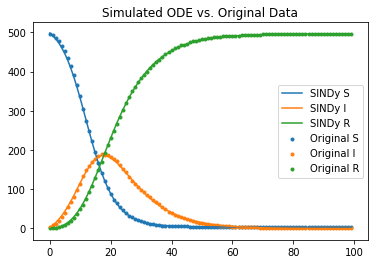

In [112]:
T_pred = np.arange(0,n)
X_sim = model.simulate(Agent_based[0,:], T_pred, )

fig1 = mplot.figure()
ax = mplot.axes()  
ax.plot(T_pred, X_sim)
ax.scatter(time, Original[:,0], marker = '.')
ax.scatter(time, Original[:,1], marker = '.')
ax.scatter(time, Original[:,2], marker = '.')
ax.legend(['SINDy S', 'SINDy I', 'SINDy R', 'Original S', 'Original I', 'Original R'])
ax.set_title('Simulated ODE vs. Original Data')

## Results and Discussion

We use the built-in grading method to determine the model's accuracy (1.00 being perfect). This is given below. Finally, we can propogate our equation forward to see if our produced ODE is stable or not. 



Model Score: 0.9851199580612452




Text(0.5, 1.0, 'Simulated ODE vs. Original Data')

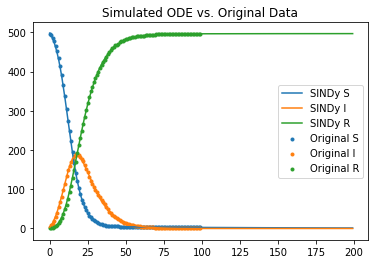

In [113]:
print('')
print('')
print('Model Score:', model.score(Original))
print('')
print('')
T_pred = np.arange(0,2*n)
X_sim = model.simulate(Agent_based[0,:], T_pred, )

fig1 = mplot.figure()
ax = mplot.axes()  
ax.plot(T_pred, X_sim)
ax.scatter(time, Original[:,0], marker = '.')
ax.scatter(time, Original[:,1], marker = '.')
ax.scatter(time, Original[:,2], marker = '.')
ax.legend(['SINDy S', 'SINDy I', 'SINDy R', 'Original S', 'Original I', 'Original R'])
ax.set_title('Simulated ODE vs. Original Data')

Here we see the differential equation propgates forward as we would expect in an SIR model. But we can now analyze the original equation.
$$
\begin{array}{l}
\dot{S} = -0.0000210 S^2 -0.0006065 SI  -0.0000165 SR  -0.0001356 I^2\\
\dot{I} = 0.0000197 S^2 + 0.0004152 SI  -0.0000192 SR  -0.0000788 I^2  -0.0002089 IR\\
\dot{R} = 0.0002012 SI + 0.0000253 SR + 0.0002125 I^2 + 0.0002110 IR
\end{array}
$$

Here can look at our potential interaction terms and how they might compare to a standard SIR model:

$$
\begin{array}{l}
\dot{S} = -\alpha\frac{SI}{N}\\
\dot{I} = \alpha\frac{SI}{N} -\beta I\\
\dot{R} = \beta I
\end{array}
$$
where $N$ is the size of the population. Comparing these two models, we notice that we do have our infectious term ($\alpha\frac{SI}{N}$) that shows how people are getting infected. However, we also notice that there are potential other nonlinear terms governing how people leave the susceptible compartment. It is worth investigating whether or not these terms would appear if multiple Agent-Based Simulations (ie trajectories) were used in the regression. 

Simialarly, we see that people do not leave the infected compartment as in the standard SIR model. Instead, the primary term govering their recovery is based on the IR (the number of infected and recovered) and paritally by $I^2$ and $SR$. 

Discussion with public health experts would be necessary to see (if any) practical interpretations of these coefficients. 


### Considering Varying Averaging Windows

If we consider different averaging windows, we can look at what SINDy produces in both equations and trajectories. Here we look at the windows of width 1,3,5,7 and what these trajectories might look like. We set our threshold to be .00001 and $\alpha =1$ for reasonable results. 

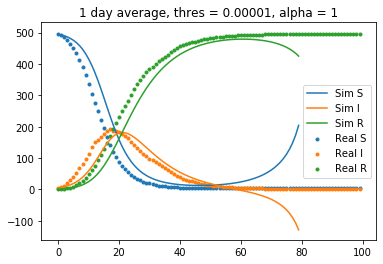

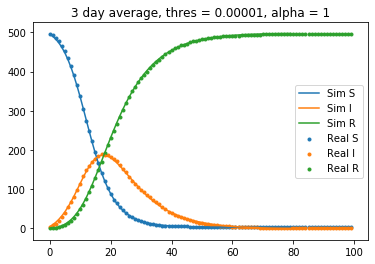

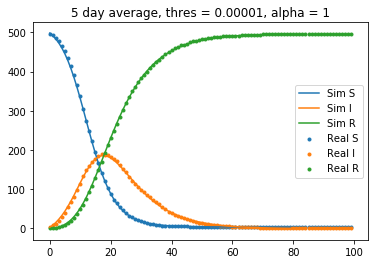

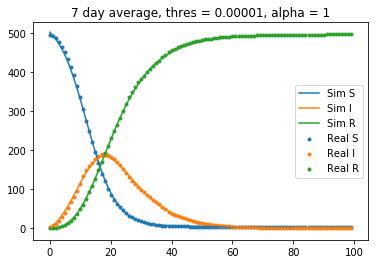

Model Score 1: 0.983213547329057
Model Score 3: 0.9873475833494947
Model Score 5: 0.9851199580612452
Model Score 7: 0.9792293565488794


In [114]:
listOfImageNames = ['First Run/Changing Avg 2/1.png',
                    'First Run/Changing Avg 2/3.png',
                    'First Run/Changing Avg 2/5.png',
                    'First Run/Changing Avg 2/7.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))
print('Model Score 1:', 0.983213547329057)
print('Model Score 3:', 0.9873475833494947)
print('Model Score 5:', 0.9851199580612452)
print('Model Score 7:', 0.9792293565488794)

Upon initial inspection of the graphs and model scores, it appears that doing a 3 day average does the best at reproducing the data. And we might ask, what happens if I propogate this forward to potentially make predictions as above. Does it behave better than the 5 day simulation because it fits the data more accurately?

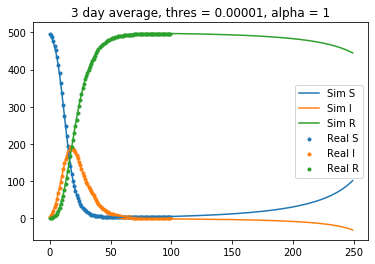

In [115]:
Image(filename = 'First Run/Changing Avg 2/3 long.png')

Clearly, this does not seem to do well when propgating forward. Here are two potential causes for this instability. 

    1. The nonlinearites used to fit the data better at the beginning caused new, long-term dynamics that are not realistic.
    2. The nonlinearities caused numerical instabilities in the calculation/simulation of the ODE.

We can, however, compare this with the 5 day window to see that we still have good long-term stability in this case. This leads me to believe that explanation 1 is more likely. 

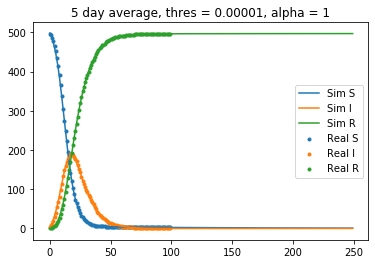

In [116]:
Image(filename = 'First Run/Changing Avg 2/5 long.png')

### Discussion of Thresholding and Other Sparse Regressors

To be updated...